In [1]:
# import ipynb.fs.defs.drc_roads_download as download_nb
# import ipynb.fs.defs.drc_roads_classification as classify_nb

In [2]:
from ipynb.fs.defs.drc_roads_download import StripDownloader
from ipynb.fs.defs.drc_roads_classification \
    import Timer, load_training_data, classify_forest, classified_band_to_rgb

In [3]:
import os

import pandas as pd
from planet import api

## Download Scenes

In this section, we use the ipynb module to import `StripDownloader` from the [drc_roads_download](drc_roads_download.ipynb) notebook. We then use `StripDownloader` to download the portion of OrthoTile strips that overlap the AOI.

### Load data from drc_roads_download notebook

In [4]:
# load aoi. Saved in drc_roads_download notebook
aoi_geojson_filename = os.path.join('pre-data', 'aoi.geojson')

In [5]:
# load scenes database. Saved in drc_roads_download notebook
overlapping_scenes_filename = os.path.join('pre-data', 'overlapping-scenes')
overlapping_scenes = pd.read_pickle(overlapping_scenes_filename)

### Download portions of OrthoTile strips that overlap AOI

In [6]:
# create planet api client
planet_api_key = os.environ['PL_API_KEY']

# quick check that key is defined
assert planet_api_key, "PL_API_KEY not defined."

client = api.ClientV1(api_key=planet_api_key)

In [7]:
asset_type = 'analytic'
strip_downloader = StripDownloader(overlapping_scenes, aoi_geojson_filename, client)
strip_downloader.run(asset_type, overwrite=False, verbose=True)

9 strips
found data/943459_mosaic.tif
found data/904538_mosaic.tif
found data/915538_mosaic.tif
found data/883193_mosaic.tif
found data/879726_mosaic.tif
found data/863467_mosaic.tif
found data/758681_mosaic.tif
found data/741529_mosaic.tif
found data/739199_mosaic.tif
Nothing to download


### Get mosaic image names

In [8]:
strip_ids = overlapping_scenes.strip_id.unique().tolist()
strip_ids.sort()

In [9]:
strip_mosaics = [strip_downloader.get_filename(i) for i in strip_ids]

In [10]:
strip_mosaics

['data/739199_mosaic.tif',
 'data/741529_mosaic.tif',
 'data/758681_mosaic.tif',
 'data/863467_mosaic.tif',
 'data/879726_mosaic.tif',
 'data/883193_mosaic.tif',
 'data/904538_mosaic.tif',
 'data/915538_mosaic.tif',
 'data/943459_mosaic.tif']

## Classify Scenes

In [11]:
X_training, y_training = load_training_data()

In [12]:
with Timer():
    classified_bands = [classify_forest(img, X_training, y_training)
                        for img in strip_mosaics]

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
6 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
6 seconds
0 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


6 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
7 seconds
0 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


7 seconds
0 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


7 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
7 seconds
0 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


8 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
7 seconds
167 seconds


In [15]:
import visual

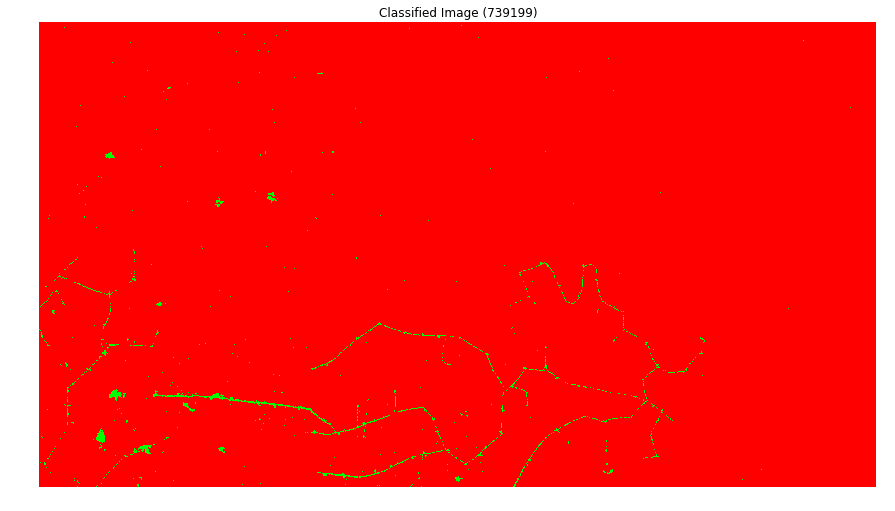

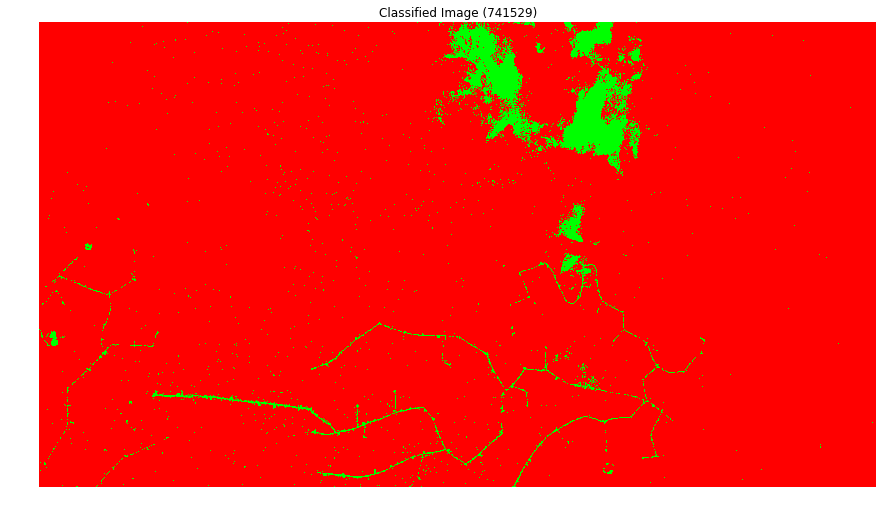

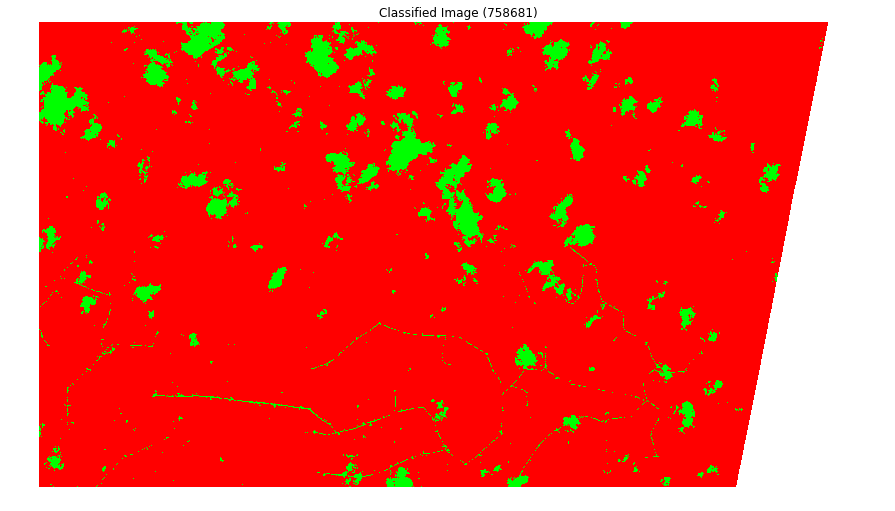

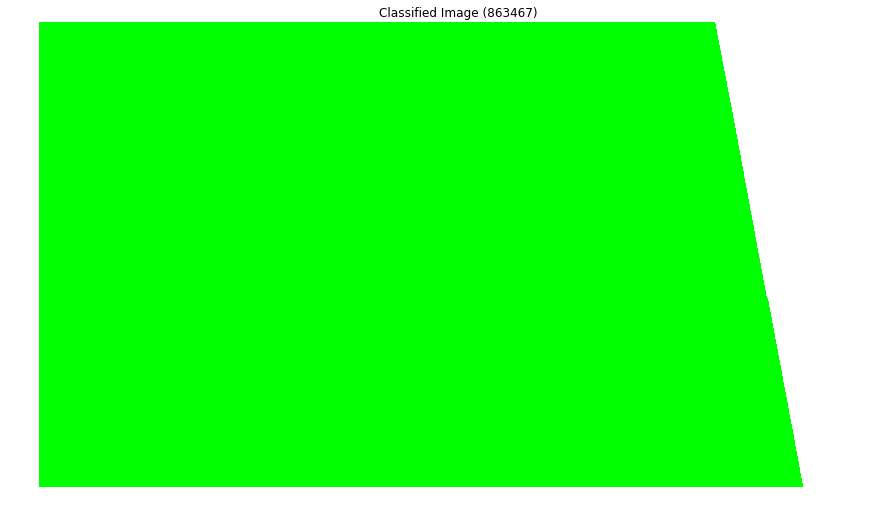

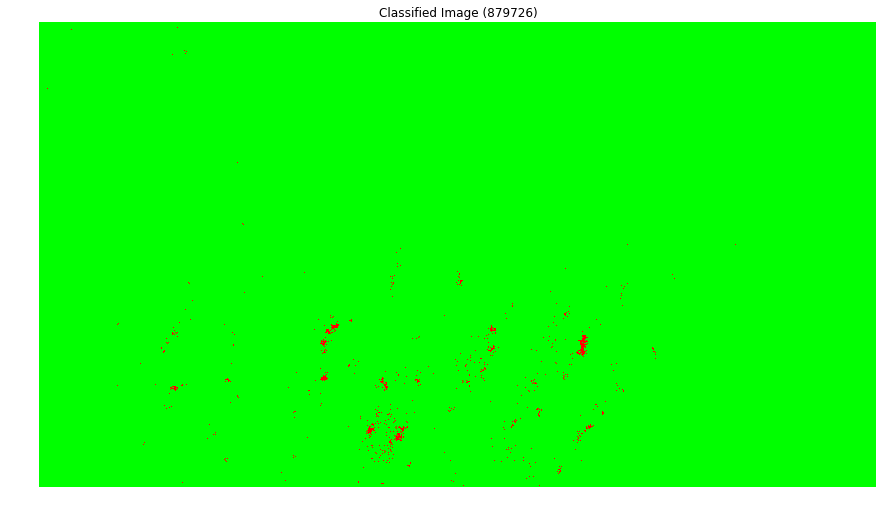

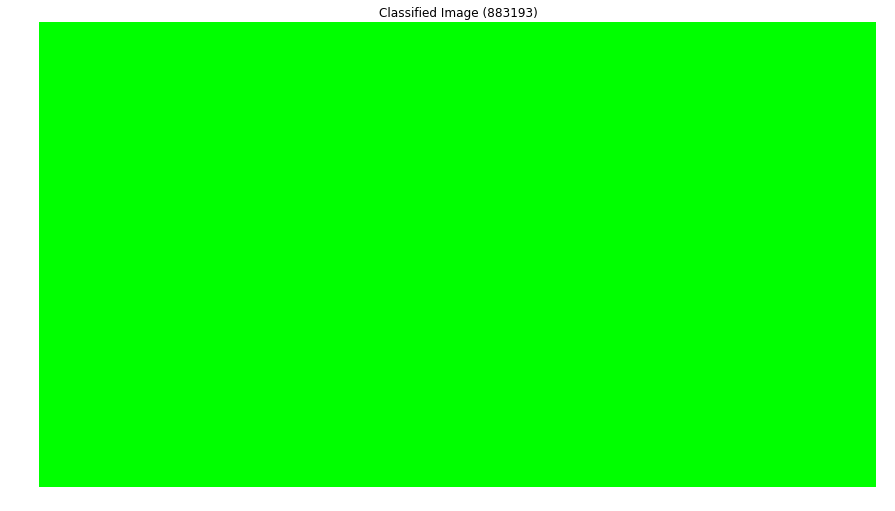

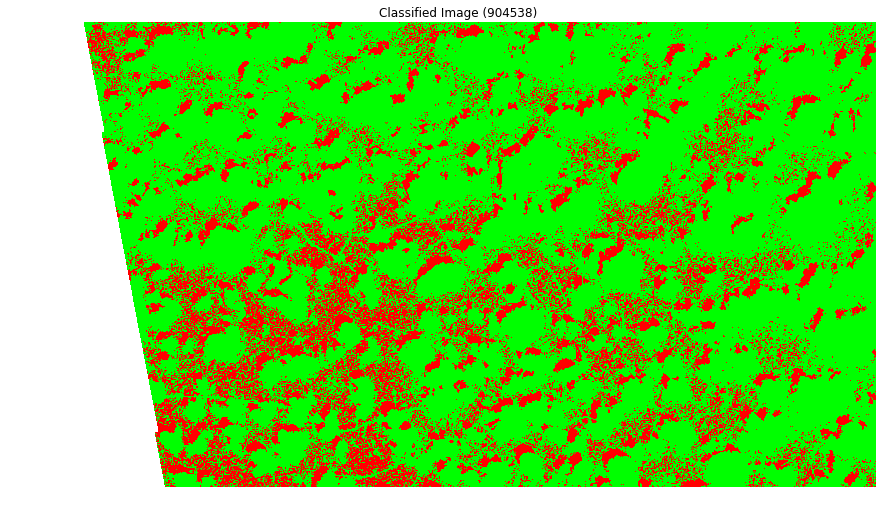

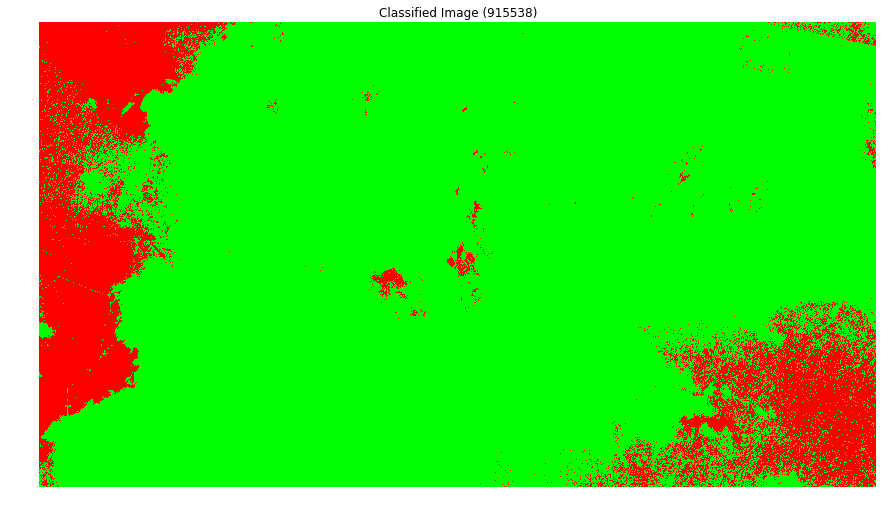

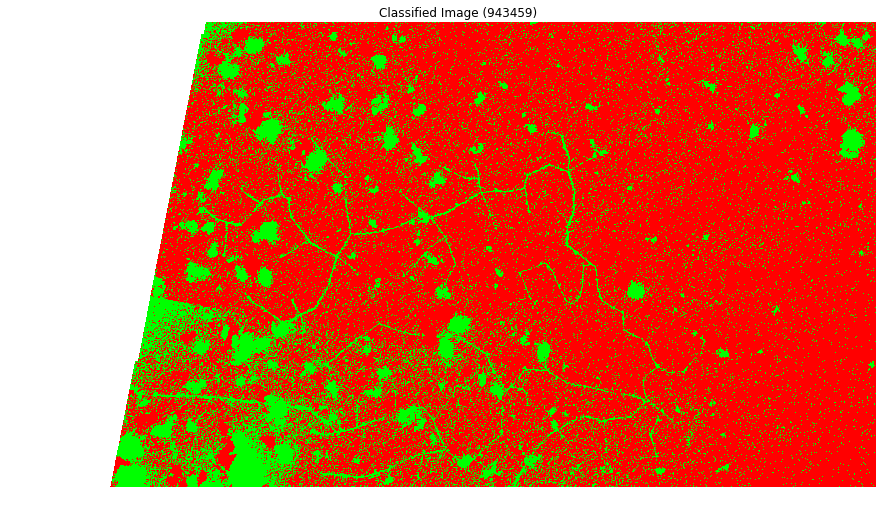

In [16]:
for classified_band, strip_id in zip(classified_bands, strip_ids):
    visual.plot_image(classified_band_to_rgb(classified_band),
                      title='Classified Image ({})'.format(strip_id),
                      figsize=(15, 15))

In looking at these classified images, the results of classification actually look really good. The issue with the ones that are classified as almost entirely non-forest is that they are primarily covered by clouds. Clouds are definately an issue here. It is tempting to dive into (1) using UDM to hopefully be able to filter out images that are primarily clouds and (2) increasing the date range to get more images after the new roads were built. But for now, let's forge on and see what temporal classification can get us,

## Temporal Classification

Lets look at the time series information for each pixel and see if we can identify true change